In [17]:
import pdfplumber
import re

import numpy as np

from sklearn import metrics
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

In [7]:
pdf = pdfplumber.open("test2.pdf")

In [8]:
p0 = pdf.pages[0]

In [9]:
im = p0.to_image()

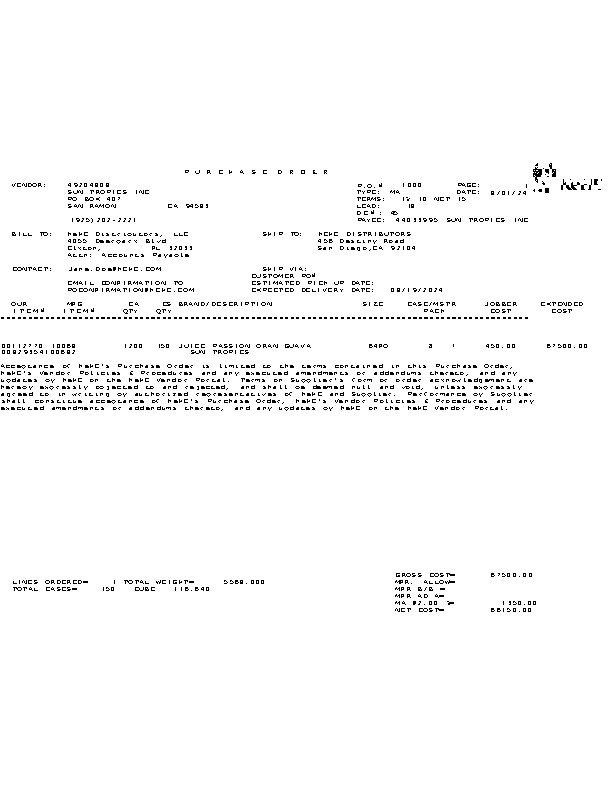

In [10]:
im

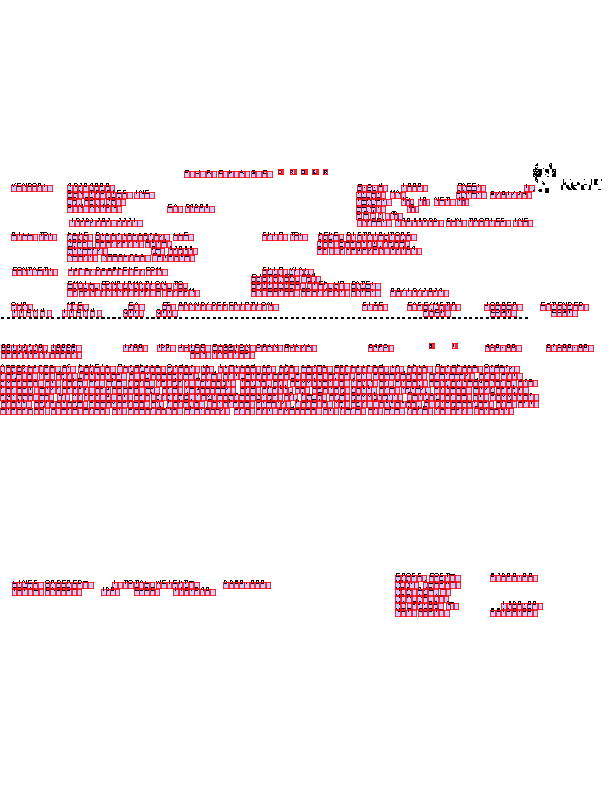

In [11]:
im.reset().draw_rects(p0.chars)

In [12]:
chars = p0.chars
chars

[{'matrix': (1, 0, 0, 1, 11.16, 604.57),
  'fontname': 'STDTXJ+CourierNew',
  'adv': 5.460000000000001,
  'upright': True,
  'x0': 11.16,
  'y0': 599.8100000000001,
  'x1': 16.62,
  'y1': 606.8100000000001,
  'width': 5.460000000000001,
  'height': 7.0,
  'size': 7.0,
  'mcid': None,
  'tag': None,
  'object_type': 'char',
  'page_number': 1,
  'ncs': 'DeviceGray',
  'text': 'V',
  'stroking_color': None,
  'stroking_pattern': None,
  'non_stroking_color': None,
  'non_stroking_pattern': None,
  'top': 185.18999999999994,
  'bottom': 192.18999999999994,
  'doctop': 185.18999999999994},
 {'matrix': (1, 0, 0, 1, 16.334000000000003, 604.57),
  'fontname': 'STDTXJ+CourierNew',
  'adv': 5.460000000000001,
  'upright': True,
  'x0': 16.334000000000003,
  'y0': 599.8100000000001,
  'x1': 21.794000000000004,
  'y1': 606.8100000000001,
  'width': 5.460000000000001,
  'height': 7.0,
  'size': 7.0,
  'mcid': None,
  'tag': None,
  'object_type': 'char',
  'page_number': 1,
  'ncs': 'DeviceGray',


In [48]:
# p0_coords = [((char['x1'] - char['x0']) / 2, (char['y1'] - char['y0']) / 2) for char in chars]
p0_coords = [(char['x1'], char['y1']) for char in chars]

p0_coords
p0_coords = np.array(p0_coords)

In [87]:
db = DBSCAN(eps=13, min_samples=5).fit(p0_coords)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 36
Estimated number of noise points: 7


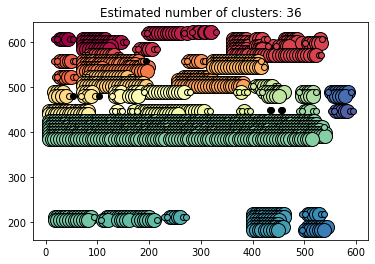

In [88]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = p0_coords[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = p0_coords[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

In [25]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=0.4, random_state=0
)
X

array([[ 0.84022039,  1.14802236],
       [-1.15474834, -1.2041171 ],
       [ 0.67863613,  0.72418009],
       ...,
       [ 0.26798858, -1.27833405],
       [-0.88628813, -0.30293249],
       [ 0.60046048, -1.29605472]])

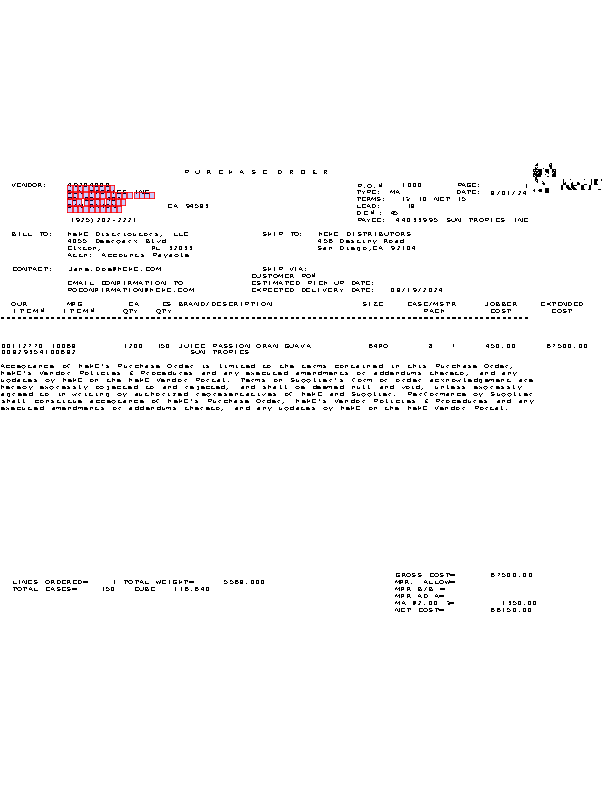

In [286]:
points = []
for i in range(len(labels)):
    if labels[i] == 1:
        points.append(i)

group = [p0.chars[i] for i in points]
im.reset().draw_rects(group)

In [287]:
text = "".join([char["text"] for char in group])
# text

# for char in group:
#     print(char['text'])

In [288]:
import itertools

# get bounding box...
x_coords = [[char['x0'], char['x1']] for char in group]
x_coords = list(itertools.chain.from_iterable(x_coords))

x0 = min(x_coords)
x1 = max(x_coords)
top = min([char['top'] for char in group])
bottom = max([char['bottom'] for char in group])

bounding_box = (x0, top, x1, bottom)
print(bounding_box)

(67.2, 185.18999999999994, 154.602, 213.08000000000004)


In [289]:
cropped = p0.crop(bounding_box)

In [290]:
cropped.extract_text()

'49204808\nSUN TROPICS INC\nPO BOX 407\nSAN RAMON'

In [291]:
im2 = cropped.to_image()
im2